Part I: Classification

1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
import pylab
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
import re
import pylab as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy.random as nprnd
pd.set_option('display.max_columns', 500)
%matplotlib inline
import random

df = pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv', index_col=0)
df.head()

/Users/yumeichen/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


2) Convert `default` and `student` to categorical variables.

In [2]:
df = df.replace('No',0)
df = df.replace('Yes',1)
df.head()

,default,student,balance,income
1,0,0,729.526495,44361.625074
2,0,1,817.180407,12106.134700
3,0,0,1073.549164,31767.138947
4,0,0,529.250605,35704.493935
5,0,0,785.655883,38463.495879


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

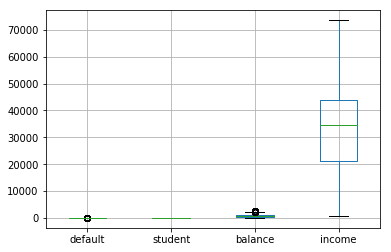

In [3]:
df.boxplot()
plt.show()

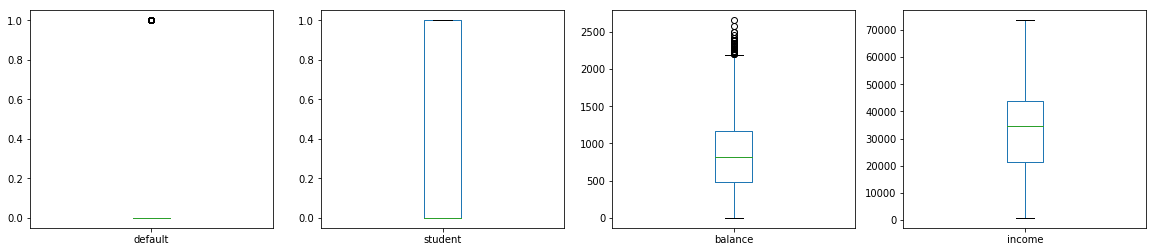

In [4]:
fig = plt.figure(figsize=(20,4))

fig1 = fig.add_subplot(1,4,1)
df['default'].plot.box()
fig2 = fig.add_subplot(1,4,2)
df['student'].plot.box()
fig3 = fig.add_subplot(1,4,3)
df['balance'].plot.box()
fig4 = fig.add_subplot(1,4,4)
df['income'].plot.box()

plt.show()

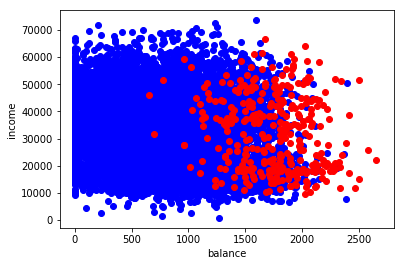

In [5]:
plt.scatter(df.balance[df['default']==0], df.income[df['default']==0],c='blue')
plt.scatter(df.balance[df['default']==1], df.income[df['default']==1],c='red')
plt.xlabel('balance')
plt.ylabel('income')
plt.show()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

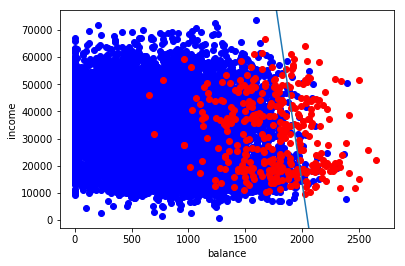

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df[['balance','income']]
y = df['default']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 37)

lr = LogisticRegression(penalty = 'l1')
lr_fit = lr.fit(X_train,y_train)

fig, ax = plt.subplots()
plt.scatter(df.balance[df['default']==0], df.income[df['default']==0],c='blue')
plt.scatter(df.balance[df['default']==1], df.income[df['default']==1],c='red')
plt.xlabel('balance')
plt.ylabel('income')

b = lr_fit.intercept_
coef = lr_fit.coef_[0]

x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

x = np.arange(x_min, x_max, 1)
y = (b + coef[0] * x) / (-coef[1])

plt.plot(x, y)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

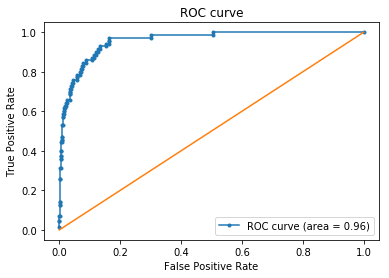

In [7]:
from sklearn.metrics import auc, roc_curve
from sklearn.datasets import make_classification

def generate_auc(X,y,clf_class,**kwargs):
    random_state = np.random.RandomState(0)
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc, thresholds

fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
def generate_roc(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    
# Plots ROC
generate_roc(fpr,tpr,'lr',roc_auc)

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

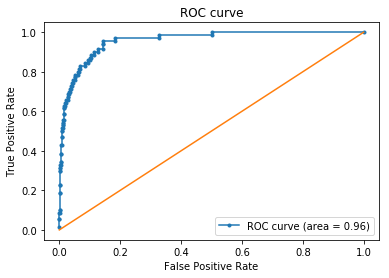

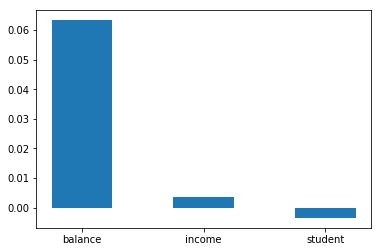

coefficient: [[  5.41538446e-03   1.92392238e-05]]
Best alpha is: 1e-06


In [9]:
from sklearn.linear_model import Ridge

X = df[['balance','income','student']]
y = df['default']
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 37)

fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
generate_roc(fpr,tpr,'lr',roc_auc)

alphas = np.logspace(-6, -1, 100)
score = []
for alpha in alphas:
    clf = Ridge(alpha=alpha)
    clf.fit(X_train, y_train)
    score.append(clf.score(X_test, y_test))
opt_index = np.array(score).argmax()

clf = Ridge(alpha=alphas[opt_index])
clf.fit(X_train, y_train)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(np.arange(3), clf.coef_, 0.5)
ax.set_xticks(np.arange(3))
ax.set_xticklabels(('balance', 'income', 'student'))
rects = ax.patches

plt.show()
print ('coefficient:',lr.coef_)
print('Best alpha is: %s' % alphas[opt_index])

The performance after added variable does not significantly increase.

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

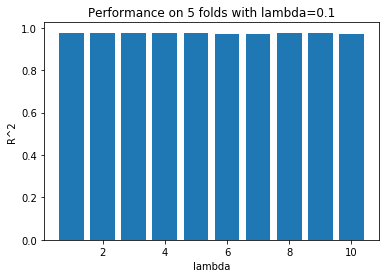

[ 0.97503121  0.97503121  0.97253433  0.97375     0.97375     0.97125     0.97
  0.97622028  0.97496871  0.96996245]


In [10]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lr, X_train, y_train, cv=10)
plt.xlabel('lambda')
plt.ylabel('R^2')
plt.bar(range(1,11),scores)
plt.title('Performance on 5 folds with lambda=0.1')
plt.show()
print(scores)

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

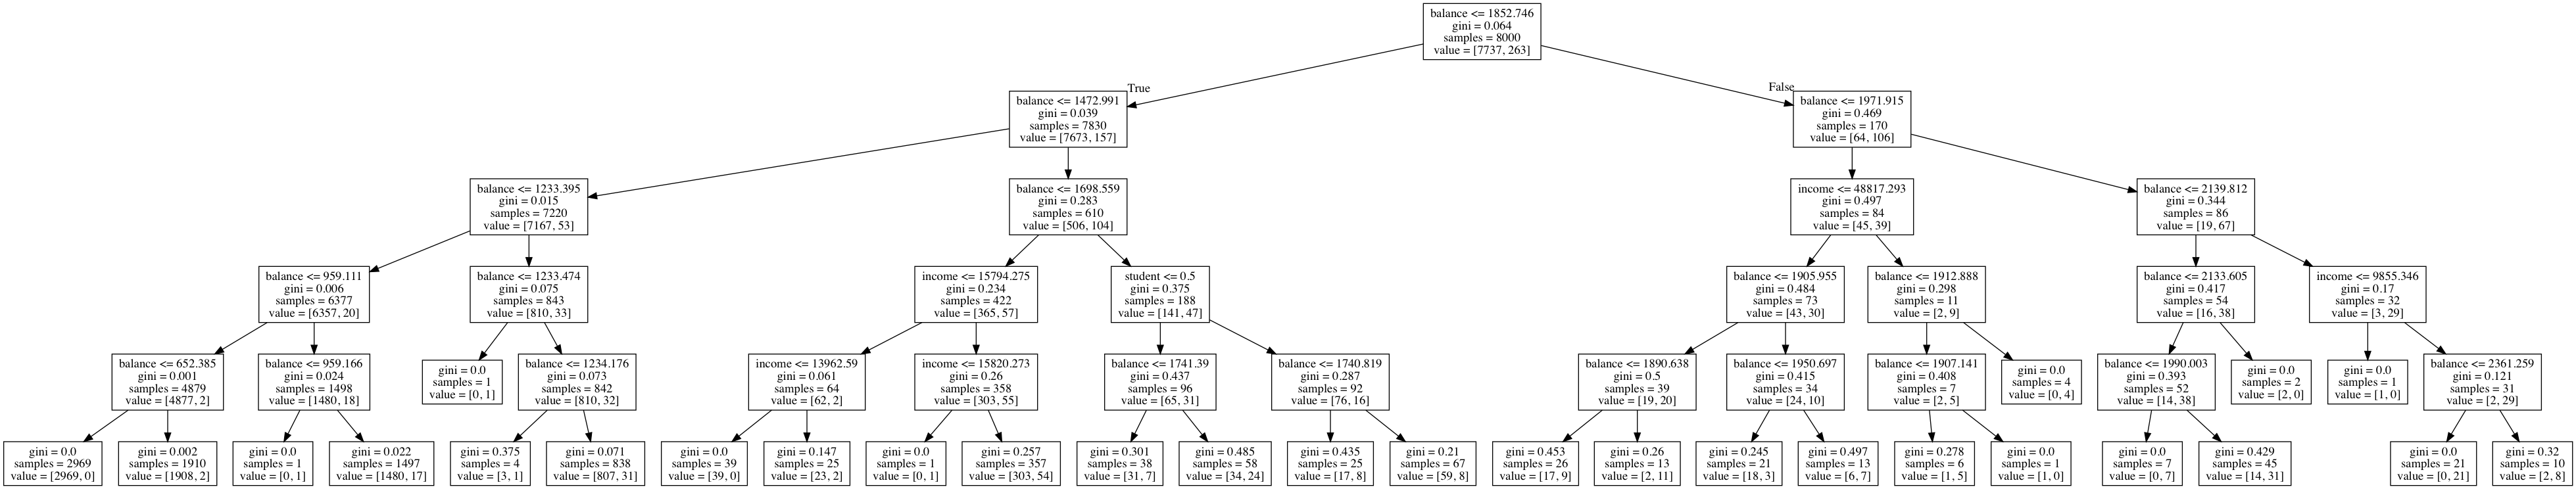

In [11]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image
from sklearn.externals.six import StringIO
import pydotplus
X = df.drop(['default'],1)
y = df.default
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 37)

dt=DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)

dot_data = StringIO()  
export_graphviz(dt, out_file=dot_data, feature_names=X_train.columns)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

8) Find the optimal decision tree depth and compute the AUC ROC. 

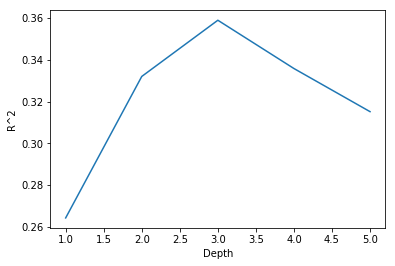

depth: 5
depth: 4


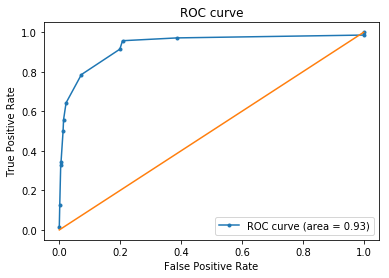

depth: 3


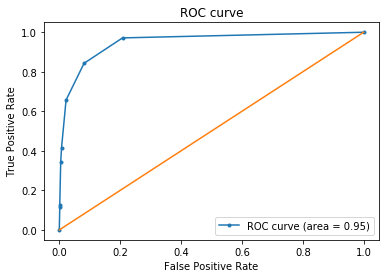

depth: 2


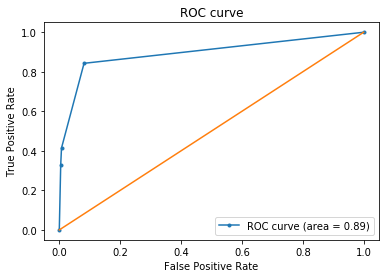

depth: 1


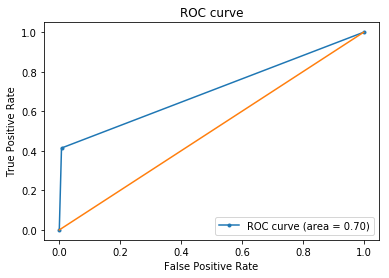

In [15]:
from sklearn.tree import DecisionTreeRegressor

train_errors=[]
test_errors=[]
scores=[]
depths = range(1,6)
for n in depths:
    regr = DecisionTreeRegressor(max_depth=n)
    # Train the model using the training sets
    regr.fit(X_train, y_train)
    train_errors.append(regr.score(X_train,y_train))
    scores.append(regr.score(X_test,y_test))
plt.ylabel('R^2')
plt.xlabel('Depth')
plt.plot(depths,scores)
test_errors=scores
n_opt=depths[np.argmax(scores)]
plt.show()

all_area=[]
print("depth:",n_opt+2)
fpr,tpr,roc_auc1, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = n_opt+2)
generate_roc
(fpr,tpr,'lr',roc_auc1)
all_area.append(roc_auc1)

print("depth:",n_opt+1)
fpr,tpr,roc_auc2, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = n_opt+1)
generate_roc(fpr,tpr,'lr',roc_auc2)
all_area.append(roc_auc2)

print("depth:",n_opt)
fpr,tpr,roc_auc3, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = n_opt)
generate_roc(fpr,tpr,'lr',roc_auc3)
all_area.append(roc_auc3)

print("depth:",n_opt-1)
fpr,tpr,roc_auc4, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = n_opt-1)
generate_roc(fpr,tpr,'lr',roc_auc4)
all_area.append(roc_auc4)

print("depth:",n_opt-2)
fpr,tpr,roc_auc5, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = n_opt-2)
generate_roc(fpr,tpr,'lr',roc_auc5)
all_area.append(roc_auc5)

max_area=max(all_area)
if max_area==roc_auc1:
    opt_depth=n_opt+2
elif max_area==roc_auc2:
    opt_depth=n_opt+1
elif max_area==roc_auc3:
    opt_depth=n_opt
elif max_area==roc_auc4:
    opt_depth=n_opt-1
elif max_area==roc_auc5:
    opt_depth=n_opt-2

The optimal depth is 3, and the auc value is 0.95.